In [ ]:
%load_ext autoreload
%autoreload 2

PROJECT_DIR = '/workspace/current/loce'

import sys

sys.path.append(PROJECT_DIR)

import pandas as pd
pd.set_option('display.max_rows', 1000)
from matplotlib import pyplot as plt

import itertools
from typing import Iterable
import seaborn as sns

from bg_randomized_loce.utils.loce_storage_helpers import all_pkls_to_npz, df_where_cols_equal
from bg_randomized_loce.utils.eval_util import with_globalized_ces, plot_cos_sim
import bg_randomized_loce
bg_randomized_loce.utils.consts.PROJECT_DIR = PROJECT_DIR
from bg_randomized_loce.utils.consts import *

results_dir = os.path.join(PROJECT_DIR, 'results')
npz_dir = os.path.join(PROJECT_DIR, 'data/results/npz')

In [ ]:
# load all concept embeddings + meta-info
orig_df = pd.DataFrame(await all_pkls_to_npz(results_dir=results_dir, npz_dir=npz_dir))#, force_update=True)

df: pd.DataFrame = with_globalized_ces(orig_df.copy(), experiment_setting_cols=EXPERIMENT_SETTING_COLS, add_depth=True)

# some validation
display(df.columns, len(df.index))
for col in EXPERIMENT_SETTING_COLS: print(col, df[col].unique())

global


ValueError: No objects to concatenate

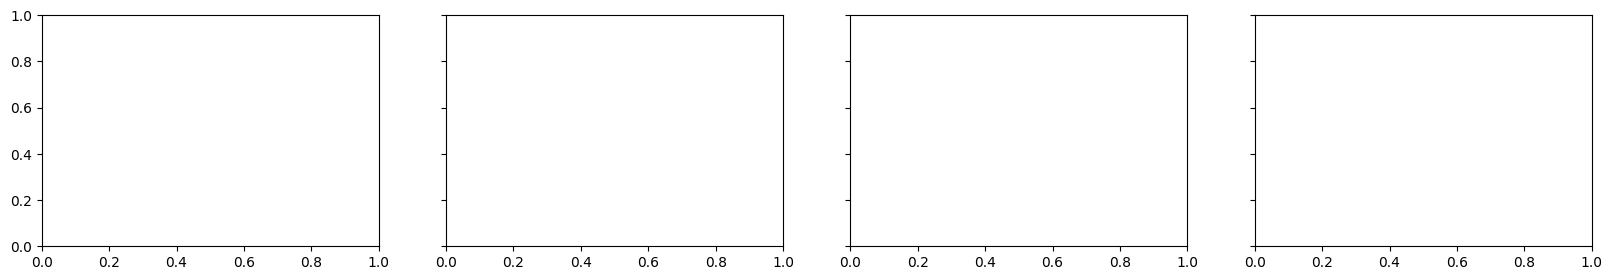

In [3]:
#nans = df[df['ce'].apply(lambda x: np.any(np.isnan(x)))]

cos_sims = {}
for glo_or_loc, idxs_ in df.groupby(by=GLO_OR_LOC).groups.items():
    print(glo_or_loc)
    settings_cols = [*EXPERIMENT_SETTING_COLS, *DERIVED_SETTINGS] \
        if glo_or_loc != 'local' else [*EXPERIMENT_SETTING_COLS, *DERIVED_SETTINGS, 'img_id']
    cos_sims[glo_or_loc] = plot_cos_sim(df.loc[idxs_], settings_cols=settings_cols)

# ## GLOBAL COSINE SIMILARITIES
# cos_sims_glo = plot_cos_sim(df_glo)
# ## LOCAL TO GLOBAL COSINE SIMILARITIES
# cos_sims_loglo = plot_cos_sim(df_loglo)
# ## LOCAL TO GLOBAL COSINE SIMILARITIES
# #cos_sims_loc = plot_cos_sim(df_loc, settings_cols=[*experiment_settings, 'img_id'])

In [ ]:
cos_sims['global'].columns, cos_sims['local'].columns

(Index(['run', 'ce_method', 'dataset_key', 'model_key', 'category_id', 'layer',
        'depth', 'global_or_local', 'level_8', 'bg_randomizer_key',
        'num_bgs_per_ce', 'cos_sim_to_vanilla', 'cos_sim_to_places',
        'cos_sim_to_places_voronoi', 'cos_sim_to_synthetic'],
       dtype='object'),
 Index(['run', 'ce_method', 'dataset_key', 'model_key', 'category_id', 'layer',
        'depth', 'global_or_local', 'img_id', 'level_9', 'bg_randomizer_key',
        'num_bgs_per_ce', 'cos_sim_to_vanilla', 'cos_sim_to_places',
        'cos_sim_to_places_voronoi', 'cos_sim_to_synthetic'],
       dtype='object'))

In [ ]:

def plot_mesh(values = [BG],
              side_by_side = [CE_METHOD],
              top_to_bottom = [DATA],
              restrict_to = {NUM_BG: 1, DEPTH: 'late'},
              pretty_names = {**PRETTY_NAMES, BG: 'Bg randomization method'},
              axsize = (3, 2)):

       # list of restrictors to be applied per columns
       side_by_side_values: Iterable[tuple] = itertools.product(*[cdf[k].unique() for k in side_by_side])
       side_by_side_setts: list[dict] = [dict(zip(side_by_side, vals)) for vals in side_by_side_values]

       # list of restrictors to be applied per row
       top_to_bottom_values: Iterable[tuple] = itertools.product(*[cdf[k].unique() for k in top_to_bottom])
       top_to_bottom_setts: list[dict] = [dict(zip(top_to_bottom, vals)) for vals in top_to_bottom_values]

       fig, axes = plt.subplots(len(top_to_bottom_setts), len(side_by_side_setts),
                                   figsize=(axsize[0] * len(side_by_side_setts), axsize[1] * len(top_to_bottom_setts)),
                                   sharex=True, sharey=True, squeeze=False)
       for ax_row, top_to_bottom_vals in zip(axes, top_to_bottom_setts):
              for ax, side_by_side_vals in zip(ax_row, side_by_side_setts):
                     curr_restrict_to = {**restrict_to, **top_to_bottom_vals, **side_by_side_vals}
                     print(curr_restrict_to)
                     cdf =  df_where_cols_equal(cos_sims['global'], curr_restrict_to)
                     cdf = (cdf.groupby(by=BG)[[*cdf[values].unique()]]
                            .mean()
                            .sort_index(axis=0).sort_index(axis=1)
                            .rename(columns=pretty_names, index=pretty_names)
                            .rename_axis(index='')
                     )
                     display(cdf.style.background_gradient(vmin=0.5, vmax=1,cmap='viridis'))

                     #cdf = cdf.drop(columns=cdf.columns[-1], index=cdf.index[0])
                     sns.heatmap(cdf, cmap='mako', #square=True,
                            annot=cdf,
                            vmin=0., vmax=1,
                            #mask=np.array([[0]*(i+1) + [1]*(len(cdf.columns)-i-1) for i in range(len(cdf.columns))]).reshape(len(cdf.columns), -1),
                            xticklabels=cdf.columns.values, yticklabels=cdf.columns.values,
                            ax=ax)
       return fig


KeyError: 'ce_method'